# Vision Language Model (VLM) Integration with ROS 2

In this notebook, we'll integrate Vision Language Models with ROS 2, demonstrating how to build intelligent vision services that can understand and describe what robots see. 

By combining VLM capabilities with ROS 2's service infrastructure, we can create reliable query-response pipelines for autonomous robots, enabling natural language interaction with visual scenes.

While in the NPU section we showed how to integrate hardware acceleration in a Publisher/Subscriber pipeline, here we will set up a VLM service using ROS 2's request-response pattern.

## Goals

* Understand the llama.cpp OpenAI-compatible API
* Integrate a local VLM as a ROS 2 service using Python RCL
* Build a reliable vision-language query system using ROS 2 services
* Query VLMs with custom prompts for different vision tasks

## References

* [Understanding ROS 2 Services](https://docs.ros.org/en/kilted/Tutorials/Beginner-CLI-Tools/Understanding-ROS2-Services/Understanding-ROS2-Services.html)
* [llama.cpp Multimodal Documentation](https://github.com/ggml-org/llama.cpp/blob/master/docs/multimodal.md)

## The `vlm_ros` Package

The `vlm_ros` package provides a ROS 2 service for querying vision-language models through llama.cpp. This allows you to leverage multimodal AI within the familiar ROS ecosystem.

### Package Features

The package includes:

- **vlm_node**: ROS 2 service server that processes VLM queries
- **VLMQuery service**: Clean request/response interface (image + prompt → response)
- **OpenAI-compatible API**: Uses the standard `/v1/chat/completions` endpoint
- **cv_bridge integration**: Seamless conversion between ROS Image messages and OpenCV format

## Explore the Package Structure

Let's examine the `vlm_ros` package structure. It follows ROS 2 conventions with a service definition (`srv/VLMQuery.srv`) and the service implementation (`vlm_ros/vlm_node.py`).

In [1]:
!ls vlm_ros/

build		install  package.xml  setup.cfg  srv
CMakeLists.txt	log	 resource     setup.py	 vlm_ros


The service structure is very simple - our node will take published pictures and prompts as an input, then wait to receive a text response from the VLM.

In [7]:
!cat vlm_ros/srv/VLMQuery.srv

# Request
sensor_msgs/Image image
string prompt
---
# Response
string response


## Start llama.cpp Server

Before we can use the VLM service, we need to start the llama.cpp server with a vision-language model. The server provides an OpenAI-compatible API endpoint that our ROS node will communicate with.

**In a separate terminal**, start the llama.cpp server with a VLM model:

![](images/new_terminal.png)

```bash
unset HSA_OVERRIDE_GFX_VERSION
export PATH=/ryzers/llamacpp/build/bin/:$PATH
llama-server -hf ggml-org/SmolVLM-500M-Instruct-GGUF \
  --host 0.0.0.0 \
  --port 8080
```

Wait until you see the "server listening" message before proceeding.

```
main: server is listening on http://0.0.0.0:8080 - starting the main loop
```

**What this does:**
- Downloads the model if not already cached (stored in `~/.cache/huggingface/`)
- Loads the model into memory
- Starts an HTTP server on port 8080 with OpenAI-compatible endpoints
- Ready to accept image + text queries for VLM inference

## Test OpenAI API Server Directly

Before integrating with ROS, let's verify the llama.cpp server is working correctly by making a direct API call. This helps us understand the request/response format and confirm the VLM is functioning properly.

The OpenAI-compatible API uses a chat completions format with messages containing both text and images.

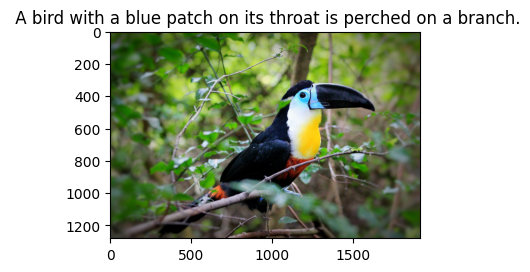

In [2]:
import base64
import json
import requests
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

LLAMA_SERVER_URL = "http://0.0.0.0:8080/v1/chat/completions"

def b64_image(image_path: str) -> str:
    """Convert image to base64 string"""
    data = Path(image_path).read_bytes()
    return base64.b64encode(data).decode("utf-8")

def ask_with_image(image_path: str, question: str):
    """Query VLM with image and question using OpenAI format"""
    payload = {
        "model": "smolvlm",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": question},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{b64_image(image_path)}"}}
                ]
            }
        ],
        "temperature": 0.2,
        "max_tokens": 256
    }
    
    r = requests.post(LLAMA_SERVER_URL, json=payload, timeout=120)
    r.raise_for_status()
    resp = r.json()
    
    # Display image
    img = cv2.imread(image_path)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(resp["choices"][0]["message"]["content"])

    # Print VLM response
    # print(resp["choices"][0]["message"]["content"])

ask_with_image("images/toucan.jpg", "What's in this image? Be concise.")

## Start the VLM Service

Now that the package is built, we can launch the VLM service node. This node provides a ROS 2 service at `/vlm_query` that accepts an image and prompt, then returns the VLM response.

**In a separate terminal**, run the VLM service:

![](images/new_terminal.png)

```bash
source /opt/ros/kilted/setup.bash
source /ryzers/notebooks/vlm_ros/install/setup.bash
ros2 run vlm_ros vlm_node
```

You should see this output:

```
[INFO] [1760575146.024196594] [vlm_node]: VLM Service ready at /vlm_query, connecting to http://localhost:8080
```

This confirms the service is running and ready to process requests.

In [3]:
import rclpy
from rclpy.node import Node
from vlm_ros.srv import VLMQuery
from cv_bridge import CvBridge
import cv2

class VLMTester(Node):
    """Test node to call VLM service"""
    def __init__(self):
        super().__init__('vlm_tester')
        self.client = self.create_client(VLMQuery, 'vlm_query')
        self.bridge = CvBridge()
        
        # Wait for service to be available
        while not self.client.wait_for_service(timeout_sec=1.0):
            self.get_logger().info('Waiting for VLM service...')
        
        print("VLM tester initialized, service ready")
        
    def query(self, image_path, prompt):
        """Query VLM with image and prompt"""
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not load image: {image_path}")
            return None
        
        # Create request
        request = VLMQuery.Request()
        request.image = self.bridge.cv2_to_imgmsg(img, encoding='bgr8')
        request.prompt = prompt
        
        # Call service
        print(f"Querying: {prompt}")
        future = self.client.call_async(request)
        rclpy.spin_until_future_complete(self, future)
        
        if future.result() is not None:
            response = future.result().response
            print(f"\nResponse: {response}\n")
            return response
        else:
            print('Service call failed')
            return None

# Initialize ROS
rclpy.init()
tester = VLMTester()

[INFO] [1761087380.347206431] [vlm_tester]: Waiting for VLM service...
[INFO] [1761087381.350941568] [vlm_tester]: Waiting for VLM service...
[INFO] [1761087382.354870318] [vlm_tester]: Waiting for VLM service...
[INFO] [1761087383.358250127] [vlm_tester]: Waiting for VLM service...
[INFO] [1761087384.360970847] [vlm_tester]: Waiting for VLM service...


VLM tester initialized, service ready


## Test with a Sample Image

Now we have a complete pipeline running:
- **llama.cpp server** serving the VLM model
- **vlm_node** providing the VLM service
- **vlm_tester** ready to call the service

Let's query the VLM with an image:

In [4]:
# Query with default prompt
tester.query('images/lena.jpg', 'Describe what you see in this image.')

Querying: Describe what you see in this image.

Response:  A black and white portrait of a young woman, she is wearing a wide brimmed hat and has long wavy hair.



' A black and white portrait of a young woman, she is wearing a wide brimmed hat and has long wavy hair.'

## Robot Planning with VLMs

The real power of this setup is the ability to ask different questions about images. Let's try the same image with different prompts:

Querying: Make a bullet point plan for the arm to put the pen into the bowl. Output only the bullets, nothing else. Use simple commands.

Response:  A pen, a plate, and a clamp lay on a table.



' A pen, a plate, and a clamp lay on a table.'

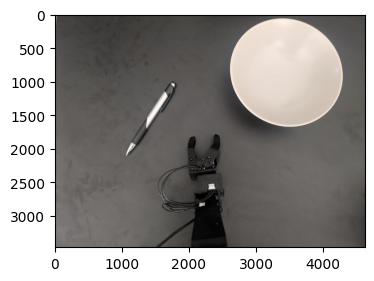

In [5]:
img = cv2.imread('images/pen_bowl.jpg')
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
tester.query('images/pen_bowl.jpg', 'Make a bullet point plan for the arm to put the pen into the bowl. Output only the bullets, nothing else. Use simple commands.')

Querying: Make a bullet point plan for the arm to put the screws into the transparent container. Output only the bullets, nothing else. Use simple commands.

Response: *   Move arm towards the container.
*   Close gripper around a screw.
*   Move gripper down into the container.
*   Lower screw into the container.
*   Open gripper.
*   Repeat steps 2-5 with the remaining screws.



'*   Move arm towards the container.\n*   Close gripper around a screw.\n*   Move gripper down into the container.\n*   Lower screw into the container.\n*   Open gripper.\n*   Repeat steps 2-5 with the remaining screws.'

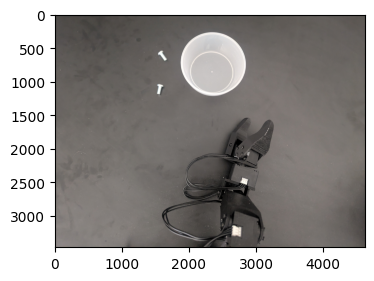

In [12]:
img = cv2.imread('images/container_screws.jpg')
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
tester.query('images/container_screws.jpg', 'Make a bullet point plan for the arm to put the screws into the transparent container. Output only the bullets, nothing else. Use simple commands.')

## Key Takeaways

Congratulations! You've successfully built a VLM-powered ROS 2 pipeline! You now understand:

* How to run llama.cpp server with vision-language models
* The OpenAI-compatible API format for multimodal requests
* How to integrate VLMs into ROS 2 using publisher-subscriber patterns
* How to bridge between ROS Image messages and base64-encoded images for API calls

## Next Steps

* Experiment with various VLM models to see quality vs. speed tradeoffs, e.g:

```bash
# Smaller, faster model
llama-server -hf ggml-org/SmolVLM-256M-Instruct-GGUF

# Larger, more powerful model
llama-server -hf ggml-org/gemma-3-4b-it-GGUF
```

* Connect a real camera using `v4l2_camera` or `image_tools` packages
* Experiment with different prompts to get better scene descriptions for your use case

## Cleanup

Make sure to ctrl+C and close the terminals before moving onto the next notebook.

**Continue to:** [4_robot_policies.ipynb](4_robot_policies.ipynb)



---
Copyright© 2025 AMD, Inc SPDX-License-Identifier: MIT